In [1]:
import os
import numpy as np
import torch

In [2]:
os.getcwd()

'/home/zhuoyuan/MyProjects/LAINR-simplified/src/plot'

In [3]:
import sys
sys.path.append('../')

In [4]:
from metrics import get_metrics
from datasets import MetaData

In [5]:
root_path = '/home/lizhuoyuan/datasets/ERA5'

In [6]:
metadata_tr: MetaData = torch.load(os.path.join(root_path, 'cached_meta_tr.pt'))
metadata_va: MetaData = torch.load(os.path.join(root_path, 'cached_meta_va.pt'))

In [7]:
trajs_tr = metadata_tr.trajs  # (ntrajs, Nsteps, *state_size, state_channels)
trajs_va = metadata_va.trajs  # (ntrajs, Nsteps, *state_size, state_channels)

ntrajs_tr, Nsteps_tr, *state_size_tr, state_channels_tr = trajs_tr.shape
ntrajs_va, Nsteps_va, *state_size_va, state_channels_va = trajs_va.shape

In [8]:
X_tr = trajs_tr.reshape(trajs_tr.shape[0] * trajs_tr.shape[1], -1)  # (N, n)
X_va = trajs_va.reshape(trajs_va.shape[0] * trajs_va.shape[1], -1)  # (N, n)

X_tr = np.float64(X_tr.numpy())  # (N, n=128x64x2=16384)
X_va = np.float64(X_va.numpy())  # (N, n=128x64x2=16384)

print(f'{X_tr.shape=}, {X_va.shape=}')

X_tr.shape=(8400, 16384), X_va.shape=(480, 16384)


In [9]:
res = np.linalg.svd(X_tr.T, full_matrices=False)  # (n, n)
print(res.U.shape)  # (16384, 4320) = (128x64x2, 18x240)
print(res.S.shape)  # (4320,)
print(res.Vh.shape)  # (4320, 4320)

(16384, 8400)
(8400,)
(8400, 8400)


In [10]:
X_tr_emb = X_tr @ res.U  # (N, n) x (n, N) = (N, N)
X_tr_rec = X_tr_emb @ res.U.T  # (N, N) x (N, n) = (N, n)
np.linalg.norm(X_tr - X_tr_rec)  # allclose

2.2098948532517243e-11

In [11]:
X_tr_emb = X_tr @ res.U[:, :1024]  # (N, n) x (n, 1024) = (N, 1024)
X_tr_rec = X_tr_emb @ res.U[:, :1024].T  # (N, 1024) x (1024, n) = (N, n)
np.linalg.norm(X_tr - X_tr_rec)  # allclose

467.39806901195834

In [12]:
X_va_emb = X_va @ res.U[:, :1024]  # (N, n) x (n, 1024) = (N, 1024)
X_va_rec = X_va_emb @ res.U[:, :1024].T  # (N, 1024) x (1024, n) = (N, n)
np.linalg.norm(X_va - X_va_rec)  # allclose

166.5984004797988

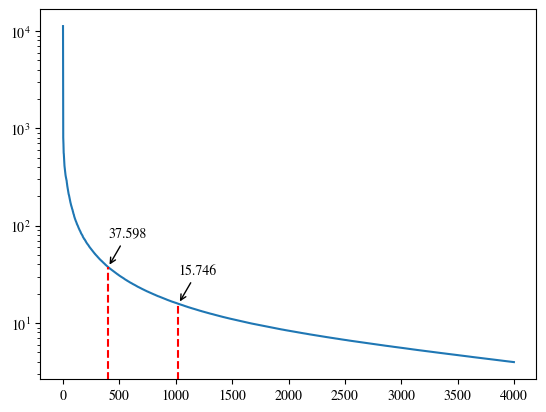

In [27]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.plot(res.S[:4000])
plt.vlines(400, 0, res.S[400], colors='r', linestyles='dashed')
plt.vlines(1024, 0, res.S[1024], colors='r', linestyles='dashed')
plt.annotate('%.3f' % res.S[400], (400, res.S[400]), xytext=(400, res.S[400] * 2), arrowprops=dict(arrowstyle='->'))
plt.annotate('%.3f' % res.S[1024], (1024, res.S[1024]), xytext=(1024, res.S[1024] * 2), arrowprops=dict(arrowstyle='->'))
plt.yscale('log')